### Import libraries

In [43]:
import os
import pandas as pd
import numpy as np

#set working directory to this from the workspace
os.chdir('/Users/janjarco/Programming/PrivateRepository/FlightDataThesisProject')

#list all the files in current working directory
print(os.listdir("data"))


['.DS_Store', 'external', 'interim', 'processed', 'raw']


#### Reading the merged data frame of orders and clicks

In [9]:
clicks_orders_merge = pd.read_csv("data/processed/clicks_orders_orderlines_merged.csv")

/var/folders/gp/cz1c1p2d6ln8dw3vyy038cwm0000gn/T/ipykernel_1889/905630692.py:1: DtypeWarning: Columns (83,100,116,123,124,126,129,130,131,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  clicks_orders_merge = pd.read_csv("data/processed/clicks_orders_orderlines_merged.csv")


In [10]:
# viewfirst 5 rows of the clicks_orders_merge
clicks_orders_merge.head()

,clicks_index,clicks_index.1,clicks_id,clicks_score,clicks_id.1,clicks_created_at,clicks_search_id,clicks_search_created_at,clicks_gate_id,clicks_meta_ref,...,orders_addon_OTHER_MUS,orders_addon_OTHER_OTHER,orders_addon_OTHER_VIP,orders_addon_SolidInsurance_BAGFO,orders_addon_SolidInsurance_FORSNY,orders_addon_climate_OTHER,orders_air_OTHER_OTHER,orders_ancillary_baggage_OTHER,orders_ancillary_carryon_OTHER,orders_fee_OTHER_OTHER
0,4,meta_clicked_itineraries,kXtIE34BCwb6y2g4GG-y,1,5009867,2022-01-01T02:36:08.000+01:00,3575609108,2022-01-01T02:13:57.000+01:00,37,BDf9_eGU1KX3T7PZ9BU9bQ,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,meta_clicked_itineraries,Lmk2E34B_h5ol0SVvXEE,1,5009860,2022-01-01T02:17:10.000+01:00,3575610283,2022-01-01T02:16:36.000+01:00,126,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,meta_clicked_itineraries,vPQ3E34BCYBP9wiWyJP8,1,5009861,2022-01-01T02:18:17.000+01:00,3575610675,2022-01-01T02:17:36.000+01:00,13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,meta_clicked_itineraries,r3s4E34BCwb6y2g4e1fR,1,5009862,2022-01-01T02:19:04.000+01:00,3575611105,2022-01-01T02:18:37.000+01:00,126,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6535,meta_clicked_itineraries,Yns_E34BCwb6y2g4LGAn,1,5009863,2022-01-01T02:26:22.000+01:00,3575613566,2022-01-01T02:24:14.000+01:00,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
clicks_orders_merge['orders_if_order'] = np.where(clicks_orders_merge['orders_order_id'].isna(),0,1)

clicks_orders_merge_filtered = clicks_orders_merge[clicks_orders_merge.orders_if_order == 1]
del clicks_orders_merge
clicks_orders_merge_filtered.shape

(137427, 152)

### Calculating distances between airports

In [12]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

airports = pd.read_csv("https://raw.githubusercontent.com/ip2location/ip2location-iata-icao/master/iata-icao.csv")
airports = airports[['iata', 'latitude', 'longitude']].rename(columns={'latitude': 'lat', 'longitude': 'lon'})

# adding some missing airports
# {'SDZ', 'IOM', 'QKL', 'JER', 'ZYR'}
airports = airports.append({'iata': 'LON', 'lat': airports.loc[airports['iata'] == 'LHR', 'lat'].values[0], 'lon': airports.loc[airports['iata'] == 'LHR', 'lon'].values[0]}, ignore_index=True)
airports = airports.append({'iata': 'PRN', 'lat': 42.6629, 'lon': 21.1655}, ignore_index=True)
airports = airports.append({'iata': 'UBN', 'lat': 47.6514, 'lon': 106.8216}, ignore_index=True)
airports = airports.append({'iata': 'SDZ', 'lat': 43.4355556, 'lon': -1.5358333}, ignore_index=True)
airports = airports.append({'iata': 'IOM', 'lat': 54.083333, 'lon': -4.623889}, ignore_index=True)
airports = airports.append({'iata': 'QKL', 'lat': 50.84722, 'lon': 6.9577}, ignore_index=True)
airports = airports.append({'iata': 'JER', 'lat': 49.207947, 'lon': -2.195508}, ignore_index=True)
airports = airports.append({'iata': 'ZYR', 'lat': 50.837091, 'lon': 4.338753}, ignore_index=True)

airports[['lat', 'lon']] = airports[['lat', 'lon']].apply(pd.to_numeric)

print(airports)

def distance_airports(str):
    if pd.isna(str):
        return np.nan
    else:
        origin, destination = str.split('-')
        origin_lon = airports.loc[airports['iata'] == origin, 'lon'].values[0]
        origin_lat = airports.loc[airports['iata'] == origin, 'lat'].values[0]
        destination_lon = airports.loc[airports['iata'] == destination, 'lon'].values[0]
        destination_lat = airports.loc[airports['iata'] == destination, 'lat'].values[0]
        try:
            return round(geodesic((origin_lat, origin_lon), (destination_lat, destination_lon)).km, 2)
        except:
            return None

print(distance_airports('CPH-WAW'))

     iata        lat        lon
0     SHJ  25.328600  55.517200
1     AZI  24.428301  54.458099
2     FJR  25.112200  56.324001
3     XSB  24.283611  52.580278
4     RKT  25.613501  55.938801
...   ...        ...        ...
8985  SDZ  43.435556  -1.535833
8986  IOM  54.083333  -4.623889
8987  QKL  50.847220   6.957700
8988  JER  49.207947  -2.195508
8989  ZYR  50.837091   4.338753

[8990 rows x 3 columns]
667.29


/var/folders/gp/cz1c1p2d6ln8dw3vyy038cwm0000gn/T/ipykernel_1889/879158621.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  airports = airports.append({'iata': 'LON', 'lat': airports.loc[airports['iata'] == 'LHR', 'lat'].values[0], 'lon': airports.loc[airports['iata'] == 'LHR', 'lon'].values[0]}, ignore_index=True)
/var/folders/gp/cz1c1p2d6ln8dw3vyy038cwm0000gn/T/ipykernel_1889/879158621.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  airports = airports.append({'iata': 'PRN', 'lat': 42.6629, 'lon': 21.1655}, ignore_index=True)
/var/folders/gp/cz1c1p2d6ln8dw3vyy038cwm0000gn/T/ipykernel_1889/879158621.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  airports = airports.append({'iata': 'UBN', 'lat': 47.6514, 'lon'

Cleaning clicks_itinerary_string string

In [13]:
clicks_orders_merge_filtered['clicks_itinerary_string'] = clicks_orders_merge_filtered['clicks_itinerary_string'].str.replace(' ','').str.strip()
clicks_orders_merge_filtered['clicks_itinerary_string'].apply(lambda x: len(x.split(','))).max()

clicks_itinerary_string_cols = clicks_orders_merge_filtered['clicks_itinerary_string'].str.replace(' ','').str.strip().str.split(',').apply(lambda x: pd.Series(x))
clicks_itinerary_string_cols.columns = ['clicks_itinerary_string_' + str(i+1) for i in clicks_itinerary_string_cols.columns]


In [14]:
clicks_itinerary_string_cols = clicks_itinerary_string_cols[['clicks_itinerary_string_' + str(i) for i in range(1,7)]]
clicks_itinerary_string_cols[clicks_itinerary_string_cols.isna().any(axis=1)]


,clicks_itinerary_string_1,clicks_itinerary_string_2,clicks_itinerary_string_3,clicks_itinerary_string_4,clicks_itinerary_string_5,clicks_itinerary_string_6
0,CPH-AGP,AGP-CPH,NaN,NaN,NaN,NaN
48,LAX-MCO,MCO-LAX,NaN,NaN,NaN,NaN
54,MUC-ALC,ALC-MUC,NaN,NaN,NaN,NaN
57,MUC-ALC,BCN-MUC,NaN,NaN,NaN,NaN
69,STO-LPA,LPA-STO,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1925509,FRA-ATH,ATH-FRA,NaN,NaN,NaN,NaN
1925520,DUS-SFO,LAS-DUS,NaN,NaN,NaN,NaN
1925539,CPH-ALC,ALC-CPH,NaN,NaN,NaN,NaN
1925562,STR-BGO,BGO-STR,NaN,NaN,NaN,NaN


Check if there are any missing airports in the database

In [15]:
from itertools import chain

#split column of dataframe into 2 by "-"
airports_all = [item for sublist in clicks_itinerary_string_cols.unstack().drop_duplicates().dropna().str.split('-') for item in sublist]
print(airports_all)
# list airpoirts in airports['iata'] that are not in airports_all
airports_in_itineraries = set([x for x in airports_all if x not in airports['iata'].values])
# print(airports_in_itineraries[:20])

['CPH', 'AGP', 'LAX', 'MCO', 'MUC', 'ALC', 'STO', 'LPA', 'CPH', 'AMS', 'STO', 'MIA', 'CPH', 'MIA', 'STO', 'LLA', 'CPH', 'BUD', 'CPH', 'POZ', 'CPH', 'NYC', 'GOT', 'PMI', 'STO', 'MLA', 'STO', 'VLC', 'ARN', 'BCN', 'GOT', 'OTP', 'GOT', 'AMS', 'ZRH', 'RUN', 'PAR', 'STO', 'ARN', 'VLC', 'BLL', 'VLC', 'FRA', 'TOS', 'TOS', 'NSI', 'STO', 'GYD', 'ARN', 'BUD', 'LPI', 'MOW', 'CPH', 'TLL', 'ARN', 'AMS', 'STO', 'LED', 'ARN', 'VIE', 'CPH', 'GOA', 'STO', 'DXB', 'HAM', 'MIA', 'CPH', 'KOA', 'BKK', 'OSL', 'BGO', 'BEG', 'SVG', 'ALC', 'CPH', 'BCN', 'CPH', 'PAR', 'OSL', 'SOF', 'ARN', 'ZRH', 'OSL', 'ROM', 'CPH', 'CMB', 'AAL', 'ALC', 'STO', 'IST', 'BLL', 'SPU', 'MUC', 'DFW', 'GOT', 'OLB', 'STO', 'BCN', 'BLL', 'BCN', 'ARN', 'AGP', 'OSL', 'DEL', 'CPH', 'MRS', 'GOT', 'AGP', 'MUC', 'JRO', 'BLL', 'NCE', 'BLL', 'LBL', 'GOT', 'LAX', 'CPH', 'STR', 'ARN', 'DXB', 'STO', 'HYD', 'AMS', 'GOT', 'CPH', 'YYC', 'STO', 'CPH', 'CPH', 'VCE', 'BGO', 'NYC', 'BER', 'BAL', 'STO', 'MMX', 'STO', 'YVR', 'GOT', 'SFO', 'OSL', 'ATH', 'CPH'

#### Final calculation of distances

In [16]:
itineraries_series = clicks_itinerary_string_cols.unstack().drop_duplicates().dropna().to_list()
itinerary_string_cols_dist = [distance_airports(i) for i in itineraries_series]

In [17]:
# create a dictionary mapping itinerary strings to their assigned values
itinerary_dist_dict = dict(zip(itineraries_series, itinerary_string_cols_dist))

# replace the values in all columns of clicks_df using applymap
clicks_itinerary_string_cols_dist = clicks_itinerary_string_cols.applymap(lambda x: itinerary_dist_dict.get(x, x))
# adding suffix "dist" to each column
clicks_itinerary_string_cols_dist.columns = clicks_itinerary_string_cols_dist.columns + '_dist'

clicks_itinerary_string_cols_dist.head()


,clicks_itinerary_string_1_dist,clicks_itinerary_string_2_dist,clicks_itinerary_string_3_dist,clicks_itinerary_string_4_dist,clicks_itinerary_string_5_dist,clicks_itinerary_string_6_dist
0,2472.80,2472.80,NaN,NaN,NaN,NaN
48,3568.99,3568.99,NaN,NaN,NaN,NaN
54,1497.81,1497.81,NaN,NaN,NaN,NaN
57,1497.81,1095.78,NaN,NaN,NaN,NaN
69,4320.61,4320.61,NaN,NaN,NaN,NaN


<Axes: >

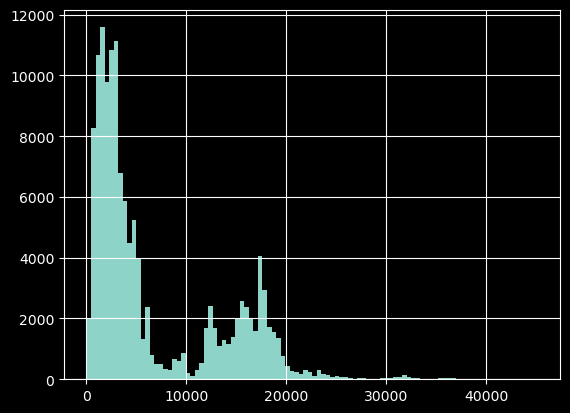

In [18]:
# merging three dataframes together 
clicks_orders_merge_filtered = pd.concat([clicks_orders_merge_filtered, clicks_itinerary_string_cols, clicks_itinerary_string_cols_dist], axis=1)

# calculating total distance of the journey
clicks_orders_merge_filtered['clicks_itinerary_totaldistance'] = clicks_orders_merge_filtered.filter(regex='_dist$').sum(axis=1, skipna=True)

# showing histogram of total distance
clicks_orders_merge_filtered['clicks_itinerary_totaldistance'].hist(bins=100)

#### Exchaning currencies

In [13]:
import requests
from requests.structures import CaseInsensitiveDict
import pandas as pd

# Define the URL of the API endpoint
URL = "https://api.freecurrencyapi.com/v1/historical?apikey=MfhFIDkrj37M0NRsdRSLlzxDu9kuXBYG8XNn2jf0"

# Define the parameters for the API request
parameters = {
    "date_from" : "2022-01-01", 
    "date_to" : "2022-12-31", 
    "base_currency" : "SEK"
}

# Make the API request
resp = requests.get(url = URL, params = parameters)

# Check the status code of the response to ensure it was successful
if resp.status_code != 200:
    print(f"Request failed with status code {resp.status_code}")
    exit(1)

# Load the response data as a JSON object
currency_data_2022 = resp.json()["data"]

In [14]:

# Define the URL of the API endpoint
URL = "https://api.freecurrencyapi.com/v1/historical?apikey=MfhFIDkrj37M0NRsdRSLlzxDu9kuXBYG8XNn2jf0"

# Define the parameters for the API request
parameters = {
    "date_from" : "2023-01-01", 
    "date_to" : "2023-03-20", 
    "base_currency" : "SEK"
}

# Make the API request
resp = requests.get(url = URL, params = parameters)

# Check the status code of the response to ensure it was successful
if resp.status_code != 200:
    print(f"Request failed with status code {resp.status_code}")
    exit(1)

# Load the response data as a JSON object
currency_data_2023 = resp.json()['data']

In [15]:
# merge currency_data_2022 and currency_data_2023
currency_data = {**currency_data_2022, **currency_data_2023}

In [16]:

# Normalize the data using Pandas and filter for data from 2021-04-27
currency_data_norm = pd.json_normalize(currency_data)
currency_data_norm

,2022-01-01.AUD,2022-01-01.BGN,2022-01-01.BRL,2022-01-01.CAD,2022-01-01.CHF,2022-01-01.CNY,2022-01-01.CZK,2022-01-01.DKK,2022-01-01.EUR,2022-01-01.GBP,...,2023-03-20.PHP,2023-03-20.PLN,2023-03-20.RON,2023-03-20.RUB,2023-03-20.SEK,2023-03-20.SGD,2023-03-20.THB,2023-03-20.TRY,2023-03-20.USD,2023-03-20.ZAR
0,0.152104,0.190151,0.616064,0.139626,0.100864,0.703814,2.414307,0.7229,0.097261,0.081764,...,5.231019,0.423019,0.442849,7.472887,1,0.128987,3.28291,1.833706,0.096424,1.785534


In [17]:
currency_data_melt = pd.melt(currency_data_norm, value_vars=currency_data_norm.columns.values, var_name='date_currency')
currency_data_melt[['date', 'currency']] = currency_data_melt['date_currency'].str.split('.', expand=True)
currency_data_melt = currency_data_melt[["currency", "date", "value"]].rename(columns={"value": "exchange_rate"})
currency_data_melt["date"] = currency_data_melt["date"]
currency_data_melt

,currency,date,exchange_rate
0,AUD,2022-01-01,0.152104
1,BGN,2022-01-01,0.190151
2,BRL,2022-01-01,0.616064
3,CAD,2022-01-01,0.139626
4,CHF,2022-01-01,0.100864
...,...,...,...
14607,SGD,2023-03-20,0.128987
14608,THB,2023-03-20,3.282910
14609,TRY,2023-03-20,1.833706
14610,USD,2023-03-20,0.096424


In [18]:
# save currency data to csv file
currency_data_melt.to_csv('data/external/currency_data.csv', index=False)

In [19]:
# read data/external/currency_data.csv to currency_data_melt
currency_data_melt = pd.read_csv('data/external/currency_data.csv')

In [20]:
clicks_orders_merge_filtered.shape

(137427, 165)

In [21]:
clicks_orders_merge_filtered['clicks_itinerary_currency'].value_counts()


SEK    59753
EUR    32856
DKK    24407
NOK    18979
Name: clicks_itinerary_currency, dtype: int64

In [45]:
from datetime import datetime, timezone
# extracting order date
clicks_orders_merge_filtered["orders_created_at_date_original"] = clicks_orders_merge_filtered.orders_created_at_date
clicks_orders_merge_filtered["orders_created_at_datetime"] = pd.to_datetime(clicks_orders_merge_filtered.orders_created_at_date_original, format='%Y-%m-%dT%H:%M:%S%z')

clicks_orders_merge_filtered["orders_created_at_datetime"] = pd.to_datetime(clicks_orders_merge_filtered.orders_created_at, unit='s')
# clicks_orders_merge_filtered["orders_created_at_datetime"]
# clicks_orders_merge_filtered["orders_created_at_datetime"] = pd.to_datetime(clicks_orders_merge_filtered["orders_created_at"], origin='unix' )
clicks_orders_merge_filtered["orders_created_at_date"] = clicks_orders_merge_filtered["orders_created_at_datetime"].dt.date.astype(str)
clicks_orders_merge_filtered["orders_created_at_time"] = clicks_orders_merge_filtered["orders_created_at_datetime"].dt.time.astype(str)

clicks_orders_merge_filtered["orders_created_at_date"]

0          2022-01-01
48         2022-01-01
54         2022-01-01
57         2022-01-01
69         2022-01-01
              ...    
1925509    2023-03-20
1925520    2023-03-20
1925539    2023-03-20
1925562    2023-03-20
1925586    2023-03-20
Name: orders_created_at_date, Length: 137427, dtype: object

Charts of distribution of orders and time in day

<Axes: >

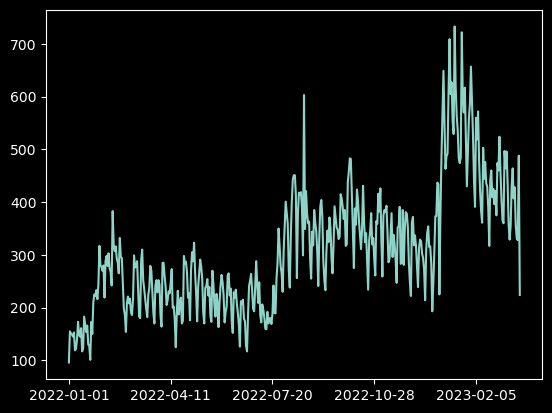

In [31]:
#visualize chart by time with number of orders per day
clicks_orders_merge_filtered["orders_created_at_date"].value_counts().sort_index().plot()

<Axes: >

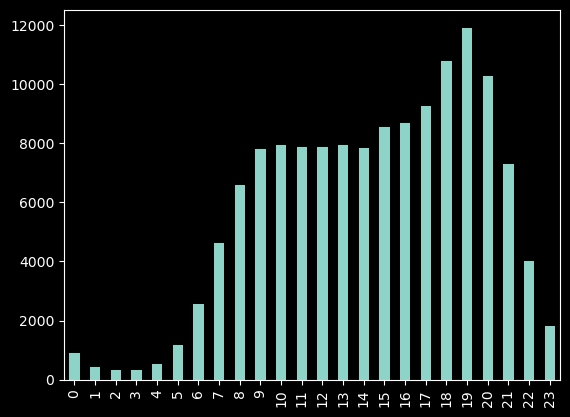

In [32]:
#visualize bar chart by time (hours:minute:seconds with number of orders per hour
clicks_orders_merge_filtered.orders_created_at_datetime.dt.hour.value_counts().sort_index().plot(kind='bar')

In [46]:
#merge clicks_orders_merge_filtered and currency_data_melt on date and currency
clicks_orders_merge_filtered_currency = pd.merge(
    # clicks_orders_merge_filtered.rename(columns={'orders_created_at_date': 'date', "clicks_itinerary_currency": "currency"}), 
    clicks_orders_merge_filtered,
    currency_data_melt, 
    how='left', 
    left_on=['orders_created_at_date', 'clicks_itinerary_currency'], 
    right_on=['date', 'currency'],
    # on=['date', 'currency'],
    suffixes=('_clicks', '_currencies')
    )
clicks_orders_merge_filtered_currency.columns.values

array(['clicks_index', 'clicks_index.1', 'clicks_id', 'clicks_score',
       'clicks_id.1', 'clicks_created_at', 'clicks_search_id',
       'clicks_search_created_at', 'clicks_gate_id', 'clicks_meta_ref',
       'clicks_searchrule_id', 'clicks_searchrule_version_id',
       'clicks_pricerule_flight_version_id',
       'clicks_pricerule_hotel_version_id',
       'clicks_pricerule_meta_version_id',
       'clicks_pricerule_ancillary_version_id',
       'clicks_presentationrule_version_id', 'clicks_uuid',
       'clicks_itinerary_string', 'clicks_ip_address', 'clicks_mobile',
       'clicks_searchrule_action_id',
       'clicks_itinerary_marketing_carriers',
       'clicks_itinerary_operating_carriers', 'clicks_itinerary_currency',
       'clicks_itinerary_sales_price', 'clicks_itinerary_sales_price_pax',
       'clicks_itinerary_segment_count', 'clicks_itinerary_direct_flight',
       'clicks_itinerary_travel_time', 'clicks_itinerary_with_baggage',
       'clicks_result_set_position',
  

In [48]:
# check if there are any null values in exchange_rate
clicks_orders_merge_filtered_currency[clicks_orders_merge_filtered_currency['exchange_rate'].isnull()]

,clicks_index,clicks_index.1,clicks_id,clicks_score,clicks_id.1,clicks_created_at,clicks_search_id,clicks_search_created_at,clicks_gate_id,clicks_meta_ref,...,clicks_itinerary_string_4_dist,clicks_itinerary_string_5_dist,clicks_itinerary_string_6_dist,clicks_itinerary_totaldistance,orders_created_at_date_original,orders_created_at_datetime,orders_created_at_time,currency,date,exchange_rate
119,511,meta_clicked_itineraries,titnGn4B22gGsIiuHGDa,1,5013541,2022-01-02T11:47:20.000+01:00,3577585898,2022-01-02T11:46:44.000+01:00,82,XFtKvbeqJpDMQU9i5RYX$Q,...,NaN,NaN,NaN,2701.76,2022-01-02,2022-01-02 10:49:50,10:49:50,NaN,NaN,NaN
309,6055,meta_clicked_itineraries,1yYhIH4BCYBP9wiWeH_c,1,5018544,2022-01-03T14:28:54.000+01:00,3579916035,2022-01-03T14:15:00.000+01:00,37,J00PXpXAc78kRfi0a0rMVw,...,NaN,NaN,NaN,3539.24,2022-01-03,2022-01-03 13:26:50,13:26:50,NaN,NaN,NaN
347,3277,meta_clicked_itineraries,t9rVLn4BE1FubMCFKn_j,1,5029381,2022-01-06T10:59:56.000+01:00,3580379175,2022-01-03T18:20:14.000+01:00,13,NaN,...,NaN,NaN,NaN,15539.78,2022-01-06,2022-01-06 10:02:20,10:02:20,NaN,NaN,NaN
392,1075,meta_clicked_itineraries,-SrXI34BynJHKtdVKuao,1,5021533,2022-01-04T07:46:15.000+01:00,3580835324,2022-01-03T21:47:01.000+01:00,13,NaN,...,NaN,NaN,NaN,2278.80,2022-01-03,2022-01-03 22:03:29,22:03:29,NaN,NaN,NaN
722,4194,meta_clicked_itineraries,OtQYLn4B_h5ol0SV4t1a,1,5028999,2022-01-06T07:34:17.000+01:00,3585016901,2022-01-06T07:06:33.000+01:00,108,foo,...,NaN,NaN,NaN,18700.83,2022-01-06,2022-01-06 06:47:00,06:47:00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136772,3980,meta_clicked_itineraries,TK4u-YYBQRoDoyeGo-ae,1,7240655,2023-03-19T10:23:18.000+01:00,4987125476,2023-03-19T09:21:26.000+01:00,37,0ZOI8ciq2YEER06PlxO_uA,...,NaN,NaN,NaN,13073.98,2023-03-19,2023-03-19 08:40:05,08:40:05,NaN,NaN,NaN
136880,5508,meta_clicked_itineraries,n8Xn-YYB4_mhf0Yp374m,1,7242155,2023-03-19T13:45:37.000+01:00,4987992038,2023-03-19T12:52:05.000+01:00,82,4IEIUy_rHYLJRoCU4SsISQ,...,NaN,NaN,NaN,1430.14,2023-03-19,2023-03-19 12:04:27,12:04:27,NaN,NaN,NaN
137031,7571,meta_clicked_itineraries,C2jk-oYBG0X-I-7xGMLd,1,7244218,2023-03-19T18:21:07.000+01:00,4989302508,2023-03-19T17:53:45.000+01:00,13,NaN,...,NaN,NaN,NaN,18059.70,2023-03-19,2023-03-19 16:58:28,16:58:28,NaN,NaN,NaN
137170,191,meta_clicked_itineraries,HWul-4YBG0X-I-7xHReQ,1,7246053,2023-03-19T21:51:57.000+01:00,4990331478,2023-03-19T21:35:56.000+01:00,75,DQ2_iwRTxokQRbucWbu1xQ,...,NaN,NaN,NaN,16742.99,2023-03-19,2023-03-19 20:46:59,20:46:59,NaN,NaN,NaN


There are 1432 values without information about currenvy at this moment they are filtered

In [49]:
# filter clicks_orders_merge_filtered_currency where exchange_rate is not null
clicks_orders_merge_filtered_currency = clicks_orders_merge_filtered_currency[clicks_orders_merge_filtered_currency['exchange_rate'].notnull()]

In [50]:
# save clicks_orders_merge_filtered_currency to csv file
clicks_orders_merge_filtered_currency.to_csv('data/processed/clicks_orders_merge_filtered_currency.csv', index=False)

Saving workspace with user input

In [29]:
import dill
import datetime

# Prompt user for confirmation
confirmation = input("Are you sure you want to save the workspace? (yes/no) ")

# Save workspace if user confirms
if confirmation == "yes":
    now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"saved_workspaces/workspace_{now}.pkl"
    with open(filename, "wb") as f:
        dill.dump_session(f)
    print("Workspace saved.")
else:
    print("Workspace not saved.")


Workspace not saved.


Loading workspace from the file

In [ ]:
import dill

# Load workspace from file
filename = "workspace.pkl"
with open(filename, "rb") as f:
    dill.load_session(f)

# Workspace variables are now available in this script
print("Workspace loaded.")
clicks_orders_merge_filtered_currency.columns.values


In [335]:
danish_exp_groupby = clicks_orders_merge_filtered.groupby(["orders_search_data.experiments.202204-danish-explanations", "orders_created_at_date"])['clicks_index'].count()

In [336]:
handbag_exp_groupby = clicks_orders_merge_filtered.groupby(["orders_search_data.experiments.202202-handbag-ordering", "orders_created_at_date"])['clicks_index'].count()